In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

LETTERS_SET = 'ABCDEFGHIKLMNOPQRSTUVWXY'

# Set random seed for reproducibility
np.random.seed(126784)


Load and perform initial exploration of the Sign Language MNIST dataset
https://www.kaggle.com/datasets/datamunge/sign-language-mnist/data

## Part 1: Data Loading and Exploration

1. Loading datasets...

Dataset Information:
--------------------------------------------------
Training set shape: (27455, 785)
Test set shape: (7172, 785)


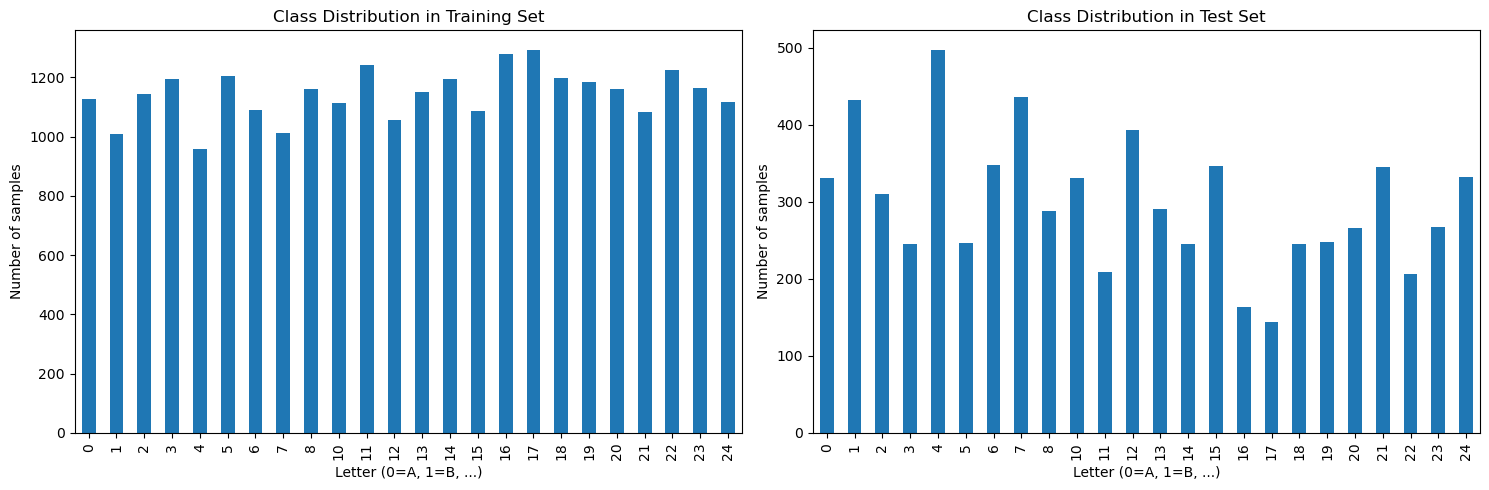

In [ ]:
print("1. Loading datasets...")
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

print("\nDataset Information:")
print("-" * 50)
print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Data distribution analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
train_data['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Letter (0=A, 1=B, ...)')
plt.ylabel('Number of samples')

plt.subplot(1, 2, 2)
test_data['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution in Test Set')
plt.xlabel('Letter (0=A, 1=B, ...)')
plt.ylabel('Number of samples')
plt.tight_layout()
plt.show()

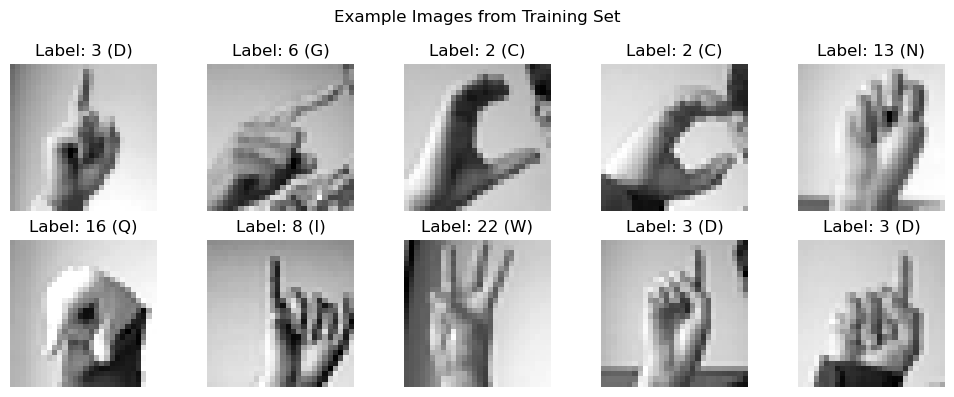

In [59]:
# Display example images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img = train_data.iloc[i, 1:].values.reshape(28, 28)
    label = train_data.iloc[i, 0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {label} ({chr(65 + label)})')

plt.suptitle('Example Images from Training Set')
plt.tight_layout()
plt.show()

In [63]:
# show data distribution to console
print("\nData Distribution:")
print("-" * 50)
print("Training set:")
print(train_data['label'].value_counts().sort_index())
print("\nTest set:")
print(test_data['label'].value_counts().sort_index())



Data Distribution:
--------------------------------------------------
Training set:
label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64

Test set:
label
0     331
1     432
2     310
3     245
4     498
5     247
6     348
7     436
8     288
10    331
11    209
12    394
13    291
14    246
15    347
16    164
17    144
18    246
19    248
20    266
21    346
22    206
23    267
24    332
Name: count, dtype: int64


## Part 2: Data Preprocessing

In [ ]:

# Separate features and labels
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values
X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

# Normalize pixel values to [0,1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Adjust labels for skipped letters (J=9, Z=25 are skipped)
def adjust_labels(y):
    return np.array([label - 1 if label > 9 else label for label in y])

y_train = adjust_labels(y_train)
y_test = adjust_labels(y_test)

# One-hot encode the labels
def to_one_hot(y, num_classes=24):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

y_train_onehot = to_one_hot(y_train)
y_test_onehot = to_one_hot(y_test)

# Print shapes for verification
print("\nProcessed data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train_onehot.shape}")
print(f"y_test: {y_test_onehot.shape}")

# Verify data ranges
print("\nData ranges after normalization:")
print(f"X_train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"X_test range: [{X_test.min():.3f}, {X_test.max():.3f}]")

# Verify class distributions
print("\nClass distribution after preprocessing:")
print("Training set:", np.bincount(y_train))
print("Test set:", np.bincount(y_test))



Processed data shapes:
X_train: (27455, 784)
X_test: (7172, 784)
y_train: (27455, 24)
y_test: (7172, 24)

Data ranges after normalization:
X_train range: [0.000, 1.000]
X_test range: [0.000, 1.000]

Class distribution after preprocessing:
Training set: [1126 1010 1144 1196  957 1204 1090 1013 1162 1114 1241 1055 1151 1196
 1088 1279 1294 1199 1186 1161 1082 1225 1164 1118]
Test set: [331 432 310 245 498 247 348 436 288 331 209 394 291 246 347 164 144 246
 248 266 346 206 267 332]


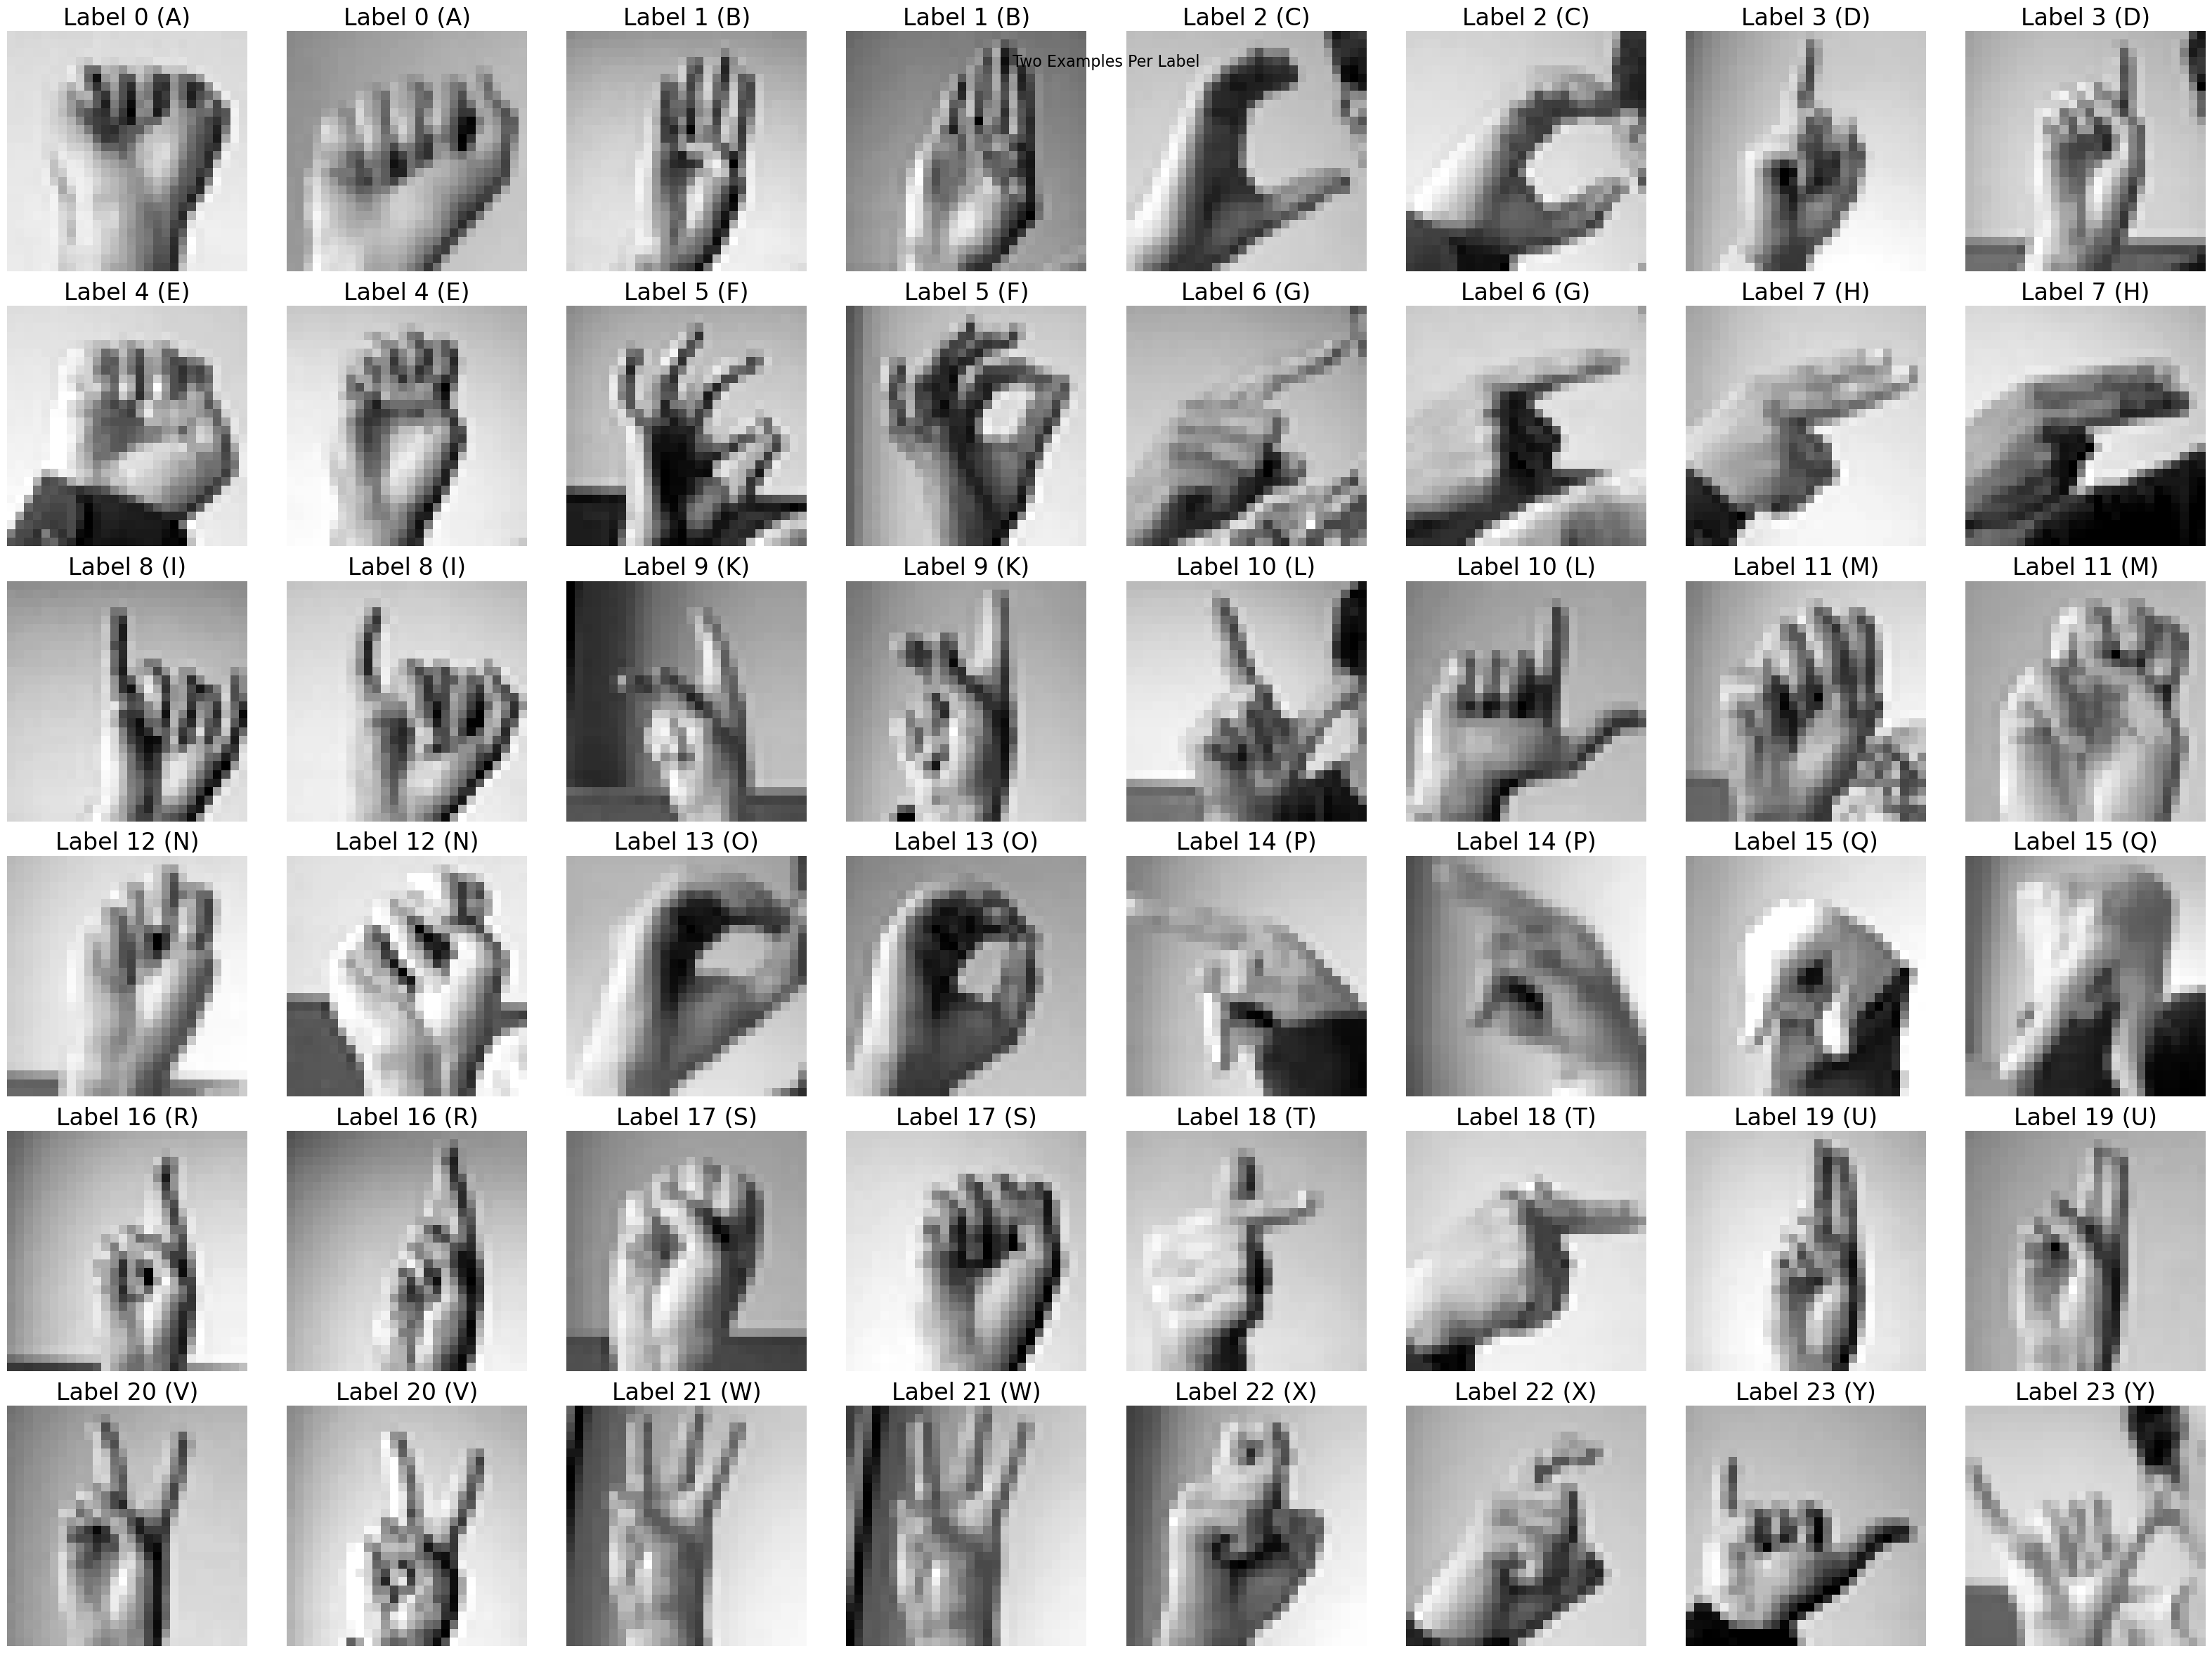

In [62]:
# Create visualization with 2 examples per class
plt.figure(figsize=(32, 24))  # Doubled the figure size

# Get indices for 2 examples of each class
examples_to_show = []
for label in range(24):
    label_indices = np.where(y_train == label)[0][:2]
    examples_to_show.extend(label_indices)

# Plot in 6x8 grid
for idx, i in enumerate(examples_to_show):
    plt.subplot(6, 8, idx + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Label {y_train[i]} ({LETTERS_SET[y_train[i]]})', fontsize=24)

plt.suptitle('Two Examples Per Label', y=0.95, fontsize=16)
plt.tight_layout()
plt.show()

## Part 3: Model Implementation

The parameter initialization is crucial for training neural networks effectively. We use a modified Xavier initialization approach which helps maintain the variance of the activations through the network.

For a layer with $n_{in}$ input units and $n_{out}$ output units, we calculate scaling factors $\epsilon$ as:

$$\epsilon = \sqrt{\frac{6}{n_{in} + n_{out}}}$$

For our two-layer network:

First layer scaling: $\epsilon_1 = \sqrt{\frac{6}{input\_size + hidden\_size}}$

Second layer scaling: $\epsilon_2 = \sqrt{\frac{6}{hidden\_size + output\_size}}$

The weights are then initialized uniformly in the range $[-\epsilon, \epsilon]$ using:

$$W_1 \sim U(-\epsilon_1, \epsilon_1) \in \mathbb{R}^{hidden\_size \times input\_size}$$
$$W_2 \sim U(-\epsilon_2, \epsilon_2) \in \mathbb{R}^{output\_size \times hidden\_size}$$

Biases are initialized to zero:
$$b_1 = 0 \in \mathbb{R}^{hidden\_size \times 1}$$
$$b_2 = 0 \in \mathbb{R}^{output\_size \times 1}$$

This initialization helps prevent the vanishing/exploding gradient problem by maintaining the variance of the activations and gradients across layers.

In [ ]:
def initialize_parameters(input_size, hidden_size, output_size):
    """
    Improved initialization using better Xavier scaling
    """
    epsilon_1 = np.sqrt(6) / np.sqrt(input_size + hidden_size)
    epsilon_2 = np.sqrt(6) / np.sqrt(hidden_size + output_size)

    parameters = {
        'W1': np.random.rand(hidden_size, input_size) * 2 * epsilon_1 - epsilon_1,
        'b1': np.zeros((hidden_size, 1)),
        'W2': np.random.rand(output_size, hidden_size) * 2 * epsilon_2 - epsilon_2,
        'b2': np.zeros((output_size, 1))
    }
    return parameters

The sigmoid (or logistic) activation function transforms any real-valued number into a value between 0 and 1. It's defined as:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

In our implementation, we clip the input values to $[-500, 500]$ for numerical stability to prevent overflow/underflow issues during computation.

In [ ]:
def sigmoid(Z):
    """
    Compute sigmoid activation
    """
    return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))

Forward propagation in a two-layer neural network computes the predictions by moving data through the network from input to output. For an input matrix $X$, the computations are:

Hidden layer:
$$Z_1 = W_1X + b_1$$ 
$$A_1 = \sigma(Z_1)$$

Output layer:
$$Z_2 = W_2A_1 + b_2$$ 
$$A_2 = \sigma(Z_2)$$

where:
- $A_1$ is the activation output of hidden layer
- $A_2$ is the final output prediction
- $W_1, W_2$ are the weight matrices
- $b_1, b_2$ are the bias vectors
- $\sigma$ is the sigmoid activation function

The function returns $A_2$ and caches $Z_1, A_1, Z_2, A_2$ for use in backpropagation.

In [ ]:
def forward_propagation(X, parameters):
    """
    Simplified forward propagation matching reference
    """
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']

    # First layer
    Z1 = np.dot(W1, X.T) + b1
    A1 = sigmoid(Z1)

    # Output layer
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {
        'Z1': Z1, 'A1': A1,
        'Z2': Z2, 'A2': A2
    }
    return A2, cache

The cost (loss) function measures how well the network performs on the training data. For our multi-class classification problem with $m$ examples, we use binary cross-entropy loss with L2 regularization:

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^m \sum_{k=1}^{K} [y_k^{(i)}\log(a_k^{(i)}) + (1-y_k^{(i)})\log(1-a_k^{(i)})] + \frac{\lambda}{2m}(\|W_1\|^2_F + \|W_2\|^2_F)$$

where:
- $y_k^{(i)}$ is the true label for class $k$ of example $i$
- $a_k^{(i)}$ is the predicted probability for class $k$ of example $i$
- $K$ is the number of classes (24 in our case)
- $\lambda$ is the regularization parameter
- $\|W\|^2_F$ is the Frobenius norm (sum of squared elements) of weight matrix

The first term is the average cross-entropy loss, and the second term is L2 regularization to prevent overfitting. We add a small $\epsilon$ to avoid log(0).

Would you like me to proceed with the backward propagation next?

In [ ]:
def compute_cost(A2, Y, parameters, lambda_reg):
    """
    Compute cross-entropy loss with L2 regularization
    """
    m = Y.shape[0]
    W1, W2 = parameters['W1'], parameters['W2']

    # Cross-entropy loss with epsilon for numerical stability
    epsilon = 1e-8
    log_probs = np.multiply(np.log(A2 + epsilon), Y.T) + \
                np.multiply(np.log(1 - A2 + epsilon), (1 - Y.T))
    cost = -np.sum(log_probs) / m

    # Add L2 regularization
    cost += (lambda_reg / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))

    return cost

## Part 4: Training and Evaluation Functions

Backpropagation computes gradients of the cost function with respect to parameters using the chain rule. For our two-layer network with $m$ training examples and L2 regularization:

Output layer gradients:
$$dZ_2 = A_2 - Y$$
$$dW_2 = \frac{1}{m}(dZ_2A_1^T) + \frac{\lambda}{m}W_2$$
$$db_2 = \frac{1}{m}\sum_{i=1}^m dZ_2^{(i)}$$

Hidden layer gradients:
$$dA_1 = W_2^T dZ_2$$
$$dZ_1 = dA_1 * A_1 * (1 - A_1)$$
$$dW_1 = \frac{1}{m}(dZ_1X^T) + \frac{\lambda}{m}W_1$$
$$db_1 = \frac{1}{m}\sum_{i=1}^m dZ_1^{(i)}$$

where:
- $dZ_2, dZ_1$ are the derivatives of the cost with respect to $Z_2, Z_1$
- $dW_2, dW_1$ are the derivatives of the cost with respect to weights
- $db_2, db_1$ are the derivatives of the cost with respect to biases
- $*$ denotes element-wise multiplication
- $\lambda$ is the regularization parameter

The gradients are clipped to avoid exploding gradient problems.

Would you like me to proceed with the training function next?

In [ ]:
def backward_propagation(X, Y, cache, parameters, lambda_reg):
    m = X.shape[0]
    W1, W2 = parameters['W1'], parameters['W2']
    A1, A2 = cache['A1'], cache['A2']

    dZ2 = A2 - Y.T
    dW2 = (1/m) * np.dot(dZ2, A1.T) + (lambda_reg/m) * W2
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * A1 * (1 - A1)

    # Add gradient clipping
    clip_value = 5.0
    dZ1 = np.clip(dZ1, -clip_value, clip_value)

    dW1 = (1/m) * np.dot(dZ1, X) + (lambda_reg/m) * W1
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2
    }
    return gradients

The training process minimizes the cost function using mini-batch gradient descent. For each iteration:

1. Compute current learning rate with decay:
$$\alpha_t = \alpha_0 \cdot \delta^{\lfloor t/k \rfloor}$$
where:
- $\alpha_0$ is initial learning rate
- $\delta$ is decay rate (0.95)
- $t$ is current iteration
- $k$ is decay steps (50)

2. Update parameters using momentum:
$$v_{W} = \beta v_{W} - \alpha_t \frac{\partial J}{\partial W}$$
$$W = W + v_{W}$$

where:
- $\beta$ is momentum coefficient (0.9)
- $v_{W}$ is velocity for parameter $W$
- $\frac{\partial J}{\partial W}$ is the gradient from backpropagation

For each iteration, the algorithm:
- Takes mini-batches of size $b$ from shuffled training data
- Performs forward propagation
- Computes cost
- Performs backward propagation
- Updates parameters with momentum

Training continues for a specified number of iterations or until convergence.

In [ ]:
def predict(X, parameters):
    """
    Make predictions using trained parameters
    """
    A2, _ = forward_propagation(X, parameters)
    predictions = np.argmax(A2, axis=0)

    return predictions

def train_model(parameters, learning_rate=0.1, num_iterations=200, lambda_reg=0.01,
                batch_size=64, momentum=0.9, decay_rate=0.95, decay_steps=50):
    """
    Training function matching reference implementation
    """
    costs = []
    m = X_train.shape[0]

    velocities = {
        'vW1': np.zeros_like(parameters['W1']),
        'vb1': np.zeros_like(parameters['b1']),
        'vW2': np.zeros_like(parameters['W2']),
        'vb2': np.zeros_like(parameters['b2'])
    }

    for i in range(num_iterations):
        # Decay learning rate
        current_lr = learning_rate * (decay_rate ** (i // decay_steps))

        # Shuffle training data
        permutation = np.random.permutation(m)
        X_shuffled = X_train[permutation]
        y_shuffled = y_train_onehot[permutation]

        epoch_cost = 0
        num_batches = m // batch_size

        for j in range(num_batches):
            start_idx = j * batch_size
            end_idx = min((j + 1) * batch_size, m)

            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Forward propagation
            A2, cache = forward_propagation(X_batch, parameters)

            # Compute cost
            cost = compute_cost(A2, y_batch, parameters, lambda_reg)
            epoch_cost += cost

            # Backward propagation
            gradients = backward_propagation(X_batch, y_batch, cache, parameters, lambda_reg)

            # Update parameters with momentum
            for param in ['W1', 'b1', 'W2', 'b2']:
                velocities[f'v{param}'] = momentum * velocities[f'v{param}'] - \
                                        current_lr * gradients[f'd{param}']
                parameters[param] += velocities[f'v{param}']

        epoch_cost /= num_batches
        costs.append(epoch_cost)


        train_pred = predict(X_train, parameters)
        test_pred = predict(X_test, parameters)
        train_accuracy = np.mean(train_pred == y_train) * 100
        test_accuracy = np.mean(test_pred == y_test) * 100

        if i % 10 == 0:
            print(f"Iteration {i}: Cost = {epoch_cost:.4f}, "
                    f"Train Accuracy = {train_accuracy:.2f}%, "
                    f"Test Accuracy = {test_accuracy:.2f}%, "
                    f"Learning Rate = {current_lr:.6f}")

    return parameters, costs

For a multi-class classification task with $K$ classes, we compute several evaluation metrics:

Accuracy is the proportion of correct predictions:
$$Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} \cdot 100\%$$

For each class $k$, we compute from the confusion matrix:

Precision (positive predictive value):
$$Precision_k = \frac{TP_k}{TP_k + FP_k}$$

Recall (sensitivity):
$$Recall_k = \frac{TP_k}{TP_k + FN_k}$$

F1-score (harmonic mean of precision and recall):
$$F1_k = 2 \cdot \frac{Precision_k \cdot Recall_k}{Precision_k + Recall_k}$$

where:
- $TP_k$ is True Positives for class $k$
- $FP_k$ is False Positives for class $k$
- $FN_k$ is False Negatives for class $k$

The function produces:
1. Overall accuracy
2. Confusion matrix visualization
3. Detailed classification report with per-class metrics

In [ ]:


def evaluate_model(parameters):
    """
    Evaluate model performance
    """

    predictions = predict(X_test, parameters)
    accuracy = np.mean(predictions == y_test) * 100
    label_mapping = {i: letter for i, letter in enumerate(LETTERS_SET)}

    # Convert numerical labels to letters for visualization
    y_test_letters = [label_mapping[label] for label in y_test]
    pred_letters = [label_mapping[pred] for pred in predictions]

    # Generate confusion matrix
    cm = confusion_matrix(y_test_letters, pred_letters)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=LETTERS_SET,
                yticklabels=LETTERS_SET)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    return predictions, accuracy

## Part 5: Visualization Functions

The visualize_results function provides two key visualizations to help understand the model's performance:

1. Training Cost Plot
Shows how the cost (error) of the model changes during training. This plot helps us understand if the model is learning effectively by displaying the cost values for each iteration. 

2. Prediction Examples
Displays a grid of test images along with their true and predicted labels. This visualization allows for quick visual inspection of where the model succeeds and fails in its predictions.

In [ ]:
def visualize_results(costs, predictions):
    """
    Visualize training results and predictions
    """
    # Plot training curve
    plt.figure(figsize=(10, 4))
    plt.plot(costs)
    plt.title('Training Cost Over Time')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

    # Display some predictions
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        if i < len(predictions):
            ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
            ax.set_title(f'Pred: {predictions[i]}\nTrue: {y_test[i]}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

For  the project, we will implement a two-layer neural network with the following architecture:

- Input layer: 784 units (28×28 pixel images)
- Hidden layer: 256 units with sigmoid activation
- Output layer: 24 units (24 classes) with sigmoid activation

The network parameters are:
- Learning rate: 0.1, with decay over time
- Mini-batch size: 64 examples
- L2 regularization parameter: 0.01
- Momentum coefficient: 0.9
- Number of iterations: 100

This architecture provides a good balance between model capacity and computational efficiency for our sign language classification task.

In [ ]:
# Initialize model
input_size = X_train.shape[1]
hidden_size = 256
output_size = 24
parameters = initialize_parameters(input_size, hidden_size, output_size)

# Train model
trained_parameters, costs = train_model(
    parameters,
    learning_rate=0.1,
    num_iterations=80,
    batch_size=64,
    lambda_reg=0.01,
    momentum=0.9,
    decay_rate=0.95,
    decay_steps=50
)

Iteration 0: Cost = 3.8845, Train Accuracy = 35.76%, Test Accuracy = 34.90%, Learning Rate = 0.100000
Iteration 1: Cost = 2.7329, Train Accuracy = 51.86%, Test Accuracy = 45.34%, Learning Rate = 0.100000
Iteration 2: Cost = 2.3548, Train Accuracy = 64.84%, Test Accuracy = 54.99%, Learning Rate = 0.100000
Iteration 3: Cost = 2.0672, Train Accuracy = 65.91%, Test Accuracy = 54.67%, Learning Rate = 0.100000
Iteration 4: Cost = 1.8631, Train Accuracy = 73.87%, Test Accuracy = 57.56%, Learning Rate = 0.100000
Iteration 5: Cost = 1.7423, Train Accuracy = 78.04%, Test Accuracy = 61.52%, Learning Rate = 0.100000
Iteration 6: Cost = 1.6039, Train Accuracy = 75.46%, Test Accuracy = 55.13%, Learning Rate = 0.100000
Iteration 7: Cost = 1.4856, Train Accuracy = 81.01%, Test Accuracy = 61.88%, Learning Rate = 0.100000
Iteration 8: Cost = 1.4255, Train Accuracy = 88.62%, Test Accuracy = 66.89%, Learning Rate = 0.100000
Iteration 9: Cost = 1.4396, Train Accuracy = 84.82%, Test Accuracy = 65.21%, Learn

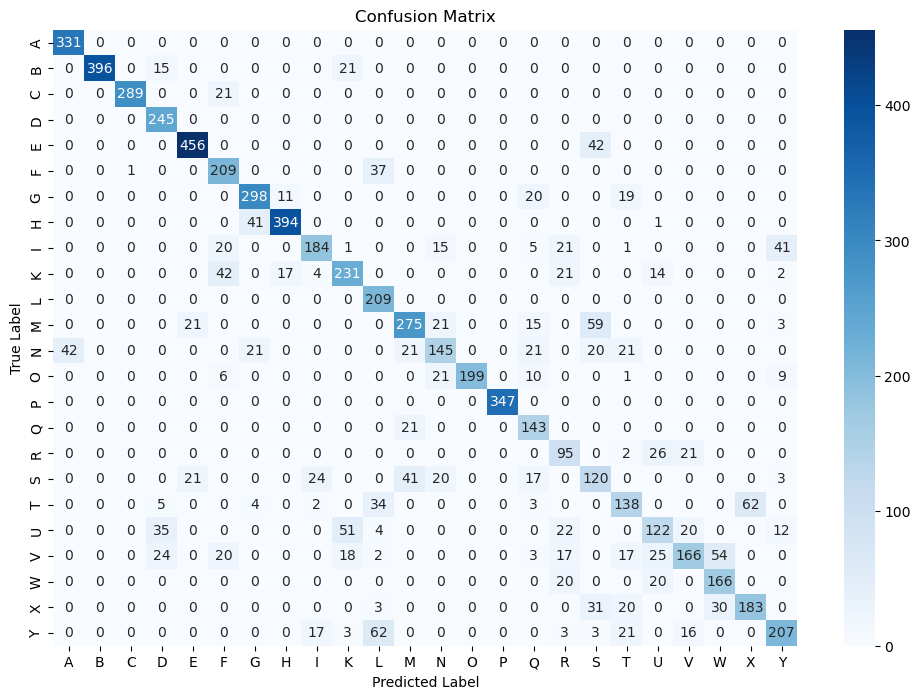


Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       331
           1       1.00      0.92      0.96       432
           2       1.00      0.93      0.96       310
           3       0.76      1.00      0.86       245
           4       0.92      0.92      0.92       498
           5       0.66      0.85      0.74       247
           6       0.82      0.86      0.84       348
           7       0.93      0.90      0.92       436
           8       0.80      0.64      0.71       288
           9       0.71      0.70      0.70       331
          10       0.60      1.00      0.75       209
          11       0.77      0.70      0.73       394
          12       0.65      0.50      0.57       291
          13       1.00      0.81      0.89       246
          14       1.00      1.00      1.00       347
          15       0.60      0.87      0.71       164
          16       0.48      0.66      0.55       144
   

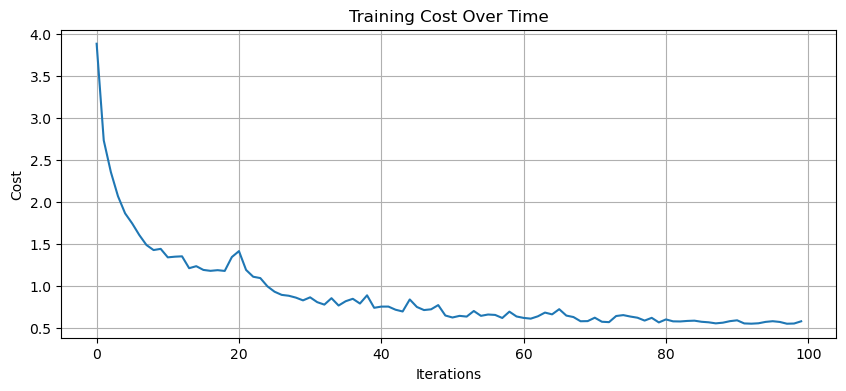

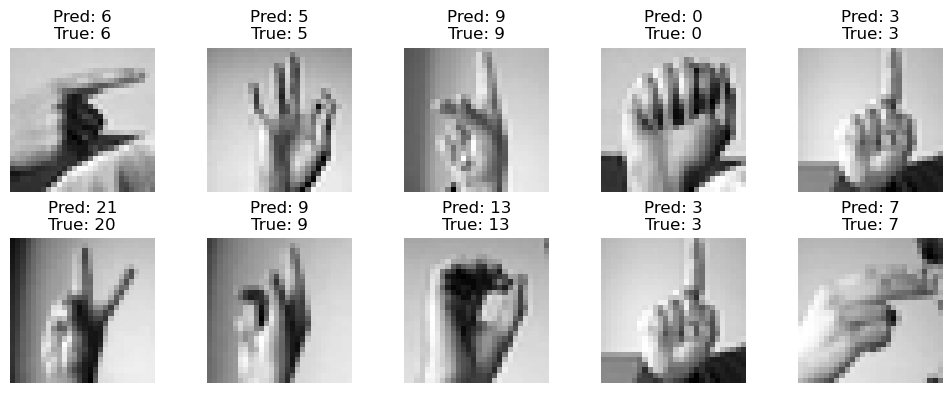

In [40]:
# Evaluate model
predictions, accuracy = evaluate_model(trained_parameters)
print(f"\nTest Accuracy: {accuracy:.2f}%")

# Visualize results
visualize_results(costs, predictions)

### Performance Overview:

| Metric | Value |
| --- | --- |
| Overall Accuracy | 77.36% |
| Macro-average F1-score | 0.75 |
| Weighted-average F1-score | 0.77 |

### Performance by Category:

| Performance Level | F1-score Range | Letters (F1-score) |
| --- | --- | --- |
| Strong | > 0.90 | A (0.94), B (0.96), C (0.96), O (1.00) |
| Moderate | 0.80-0.90 | D (0.86), E (0.92), G (0.84), H (0.92), N (0.89) |
| Poor | < 0.60 | M (0.57), Q (0.55), R (0.46), S (0.57), T (0.51) |

### Class Support Distribution:

| Support Level | Count Range | Classes |
| --- | --- | --- |
| High | > 400 | E (498), B (432), H (436) |
| Medium | 300-400 | A (331), G (348), L (394), O (347), U (346) |
| Low | < 200 | P (164), Q (144) |

### Key Observations:

1. Class Imbalance: The dataset shows significant variation in support size, ranging from 144 samples (class 16) to 498 samples (class 4)

2. Precision vs Recall Trade-offs:
   - Some classes show high precision but low recall (e.g., class 20)
   - Others show high recall but low precision (e.g., class 10)

3. Problematic Classes:
   - Class 17 (R) shows the worst performance with F1-score of 0.46
   - Letters Q, R, S, T consistently perform poorly, suggesting these signs might be more complex or similar to each other

### Potential Improvements:
1. Data Augmentation for underrepresented classes
2. Feature Engineering to better capture hand gesture details
3. Model Architecture adjustments:
   - Increase hidden layer size
   - Add additional hidden layers
   - Experiment with different learning rates
4. Implement class weights to handle class imbalance

## Appendix: Export Model and Data to JSON


In [66]:
model_dict = {
    'W1': trained_parameters['W1'].tolist(),
    'b1': trained_parameters['b1'].tolist(),
    'W2': trained_parameters['W2'].tolist(),
    'b2': trained_parameters['b2'].tolist()
}
model_dict['input_size'] = input_size
model_dict['hidden_size'] = hidden_size
model_dict['output_size'] = output_size

import json

with open('trained_model.json', 'w') as f:
    json.dump(model_dict, f)